# Proxy 输入可视化

用途：快速查看指定任务/搜索空间的 DataLoader 输入样本（用于 ZiCo/NASWOT/FLOPs 等 proxy）。

- 依赖：复用 `proxy_TransNAS/utils/load_model.py`
- 使用方式：修改下方配置后直接运行所有单元格。
- 提示：不要在显存紧张时设置过大的 `batch_size`。


In [9]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import torch

# 项目根与当前目录（notebook 环境）
CURRENT_DIR = Path.cwd()  # 或者 Path(__file__).resolve().parent if 在脚本中
ROOT_DIR = CURRENT_DIR.parent
NASLIB_ROOT = ROOT_DIR / "NASLib"

sys.path.insert(0, str(ROOT_DIR))
sys.path.insert(0, str(NASLIB_ROOT))

from proxy_TransNAS.utils.load_model import (
    load_transbench_classes,
    load_transbench_api,
    make_train_loader,
    truncate_loader,
)

# ---- 可调配置 ----
TASK = "normal"
SEARCH_SPACE = "micro"
DATA_ROOT = ROOT_DIR / "NASLib" / "data"
BATCH_SIZE = 8
MAX_BATCH = 1
SEED = 42
SAMPLE_INDICES = [0, 1, 2]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# 准备数据与搜索空间
torch.manual_seed(SEED)

TransBench101SearchSpaceMicro, TransBench101SearchSpaceMacro, graph_module = load_transbench_classes()
data_root = Path(DATA_ROOT).resolve()
dataset_api = load_transbench_api(data_root, TASK)

# 选择搜索空间
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransBench101SearchSpaceMicro(dataset=TASK, create_graph=True)
else:
    ss = TransBench101SearchSpaceMacro(dataset=TASK, create_graph=True)

# 构建 DataLoader 并截断
train_loader = make_train_loader(TASK, data_root, BATCH_SIZE, SEED)
train_batches = truncate_loader(train_loader, MAX_BATCH)

print(f"数据根: {data_root}")
print(f"任务: {TASK}, 搜索空间: {SEARCH_SPACE}, 批次数: {len(train_batches)}")


数据根: D:\Dataset\MCUFlowNet\NASLib\data
任务: normal, 搜索空间: micro, 批次数: 1


批大小: 8, 展示样本: [0, 1, 2]


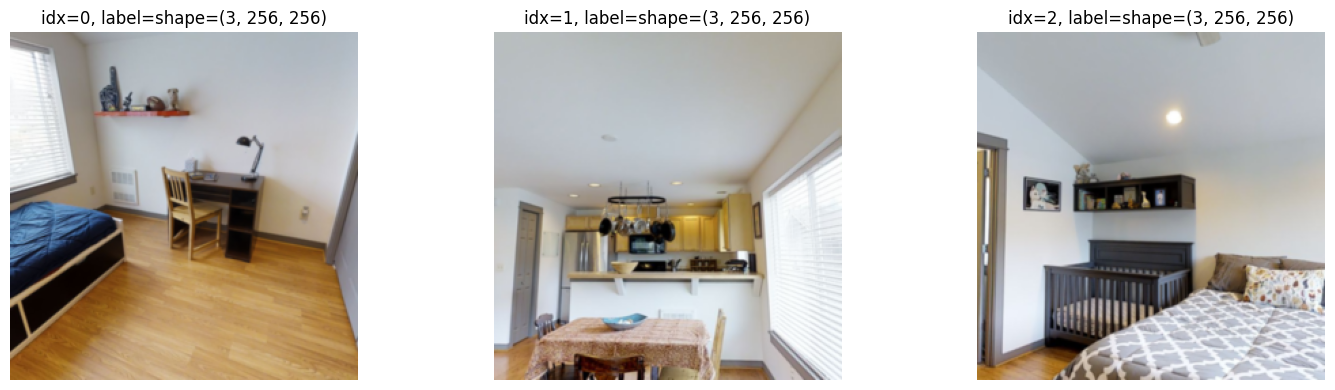

In [11]:
# 可视化选定样本
batch = train_batches[0]
images, labels = batch  # 假设 DataLoader 返回 (data, label)
images = images.cpu()
labels = labels.cpu()

n = images.shape[0]
indices = [idx for idx in SAMPLE_INDICES if 0 <= idx < n]
print(f"批大小: {n}, 展示样本: {indices}")

fig, axes = plt.subplots(1, len(indices), figsize=(5*len(indices), 4))
if len(indices) == 1:
    axes = [axes]

for ax, idx in zip(axes, indices):
    img = images[idx]
    # 处理通道：C,H,W -> H,W,C，并归一到0-1便于显示
    if img.ndim == 3:
        if img.shape[0] == 1:
            disp = img.squeeze(0)
            ax.imshow(disp, cmap="gray")
        else:
            disp = img.permute(1, 2, 0)
            # 若值域不在[0,1]，做最小-最大归一化
            imin, imax = disp.min(), disp.max()
            if (imax - imin) > 1e-6:
                disp = (disp - imin) / (imax - imin)
            ax.imshow(disp)
    else:
        ax.imshow(img, cmap="gray")

    # 标签展示：若为标量/单元素，取 item，否则显示形状
    label_tensor = labels[idx]
    if label_tensor.numel() == 1:
        label_text = str(label_tensor.item())
    else:
        label_text = f"shape={tuple(label_tensor.shape)}"
    ax.set_title(f"idx={idx}, label={label_text}")
    ax.axis("off")

plt.tight_layout()
plt.show()

